<h1>EDA</h1>

<h2>Import Libraries</h2>

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from calendar import monthrange
from itertools import product

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pickle
%matplotlib inline

from sklearn.preprocessing import LabelEncoder

<h2>Settings</h2>

In [42]:
ds_original_path = "dataset/original/"
ds_preproc_path = "dataset/preproc/"
target = "item_cnt_month"
seed = 7

<h2>Loading Datas</h2>

In [43]:
item_cats = pd.read_csv(ds_original_path + 'item_categories.csv')
items = pd.read_csv(ds_original_path + 'items.csv')
sales = pd.read_csv(ds_original_path + 'sales_train.csv')
shop = pd.read_csv(ds_original_path + 'shops.csv')
submit_sample = pd.read_csv(ds_original_path + 'sample_submission.csv')
test = pd.read_csv(ds_original_path + 'test.csv')

Let's take a first look to our datas

In [44]:
item_cats.head(5)  # sostituisci tutti i catgs
item_cats.shape

items.head(5)
items.shape

sales.head(5) 
sales.shape

shop.head(5) #sost tutti i shops
shop.shape

submit_sample.head(5) # sost i vari sampl
submit_sample.shape

test.head(5) # sost test d
test.shape

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


(84, 2)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


(22170, 3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


(2935849, 6)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


(60, 2)

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


(214200, 2)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


(214200, 3)

<h2>Data Exploration</h2>

<h3>Missing values</h3>

In [45]:
sales.isnull().sum()
test.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

ID         0
shop_id    0
item_id    0
dtype: int64

Good! There are no missing values, so we don't have to do anything about it

<h3>Outliers</h3>

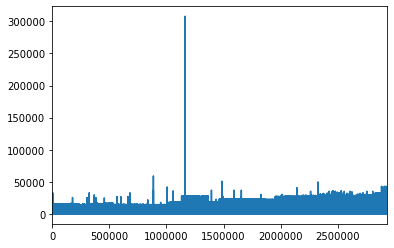

In [46]:
sales.item_price.plot()

We can notice a price outlier; let's examinate it

In [47]:
sales[sales['item_price'] > 50000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
885138,17.09.2013,8,12,11365,59200.0,1.0
1163158,13.12.2013,11,12,6066,307980.0,1.0
1488135,20.03.2014,14,25,13199,50999.0,1.0


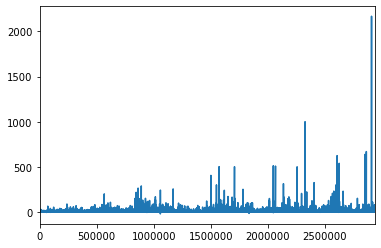

In [48]:
sales.item_cnt_day.plot()

We can notice 2 outliers of items solds; let's examinate it

In [49]:
sales[sales['item_cnt_day'] > 900]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2326930,15.01.2015,24,12,20949,4.000000,1000.0
2909818,28.10.2015,33,12,11373,0.908714,2169.0


Let's filters those outliers

In [50]:
time_mask = (sales['item_cnt_day'] < 900) & (sales['item_price'] < 50000)
sales = sales[time_mask]
sales.shape

(2935844, 6)

Now let's see if there are other meaningful informations

In [51]:
sales.describe()
sales.info()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935844e+06,2.935844e+06,2.935844e+06,2.935844e+06,2.935844e+06
mean,1.456991e+01,3.300176e+01,1.019722e+04,8.907123e+02,1.241563e+00
std,9.422987e+00,1.622697e+01,6.324299e+03,1.719906e+03,2.217636e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,4.978200e+04,6.690000e+02


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935844 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 156.8+ MB


In [52]:
shop.shop_name

0                       !Якутск Орджоникидзе, 56 фран
1                       !Якутск ТЦ "Центральный" фран
2                                    Адыгея ТЦ "Мега"
3                      Балашиха ТРК "Октябрь-Киномир"
4                            Волжский ТЦ "Волга Молл"
5                              Вологда ТРЦ "Мармелад"
6                          Воронеж (Плехановская, 13)
7                              Воронеж ТРЦ "Максимир"
8                        Воронеж ТРЦ Сити-Парк "Град"
9                                   Выездная Торговля
10                         Жуковский ул. Чкалова 39м?
11                         Жуковский ул. Чкалова 39м²
12                                Интернет-магазин ЧС
13                                Казань ТЦ "Бехетле"
14                            Казань ТЦ "ПаркХаус" II
15                               Калуга ТРЦ "XXI век"
16                                   Коломна ТЦ "Рио"
17                      Красноярск ТЦ "Взлетка Плаза"
18                          

We can notice how in those shops name there are some recurrent values, like "ТЦ", "ТК" and so on..
This can be useful for binning.

A similar concept is present on the item categories

In [53]:
item_cats.item_category_name.unique()

array(['PC - Гарнитуры/Наушники', 'Аксессуары - PS2', 'Аксессуары - PS3',
       'Аксессуары - PS4', 'Аксессуары - PSP', 'Аксессуары - PSVita',
       'Аксессуары - XBOX 360', 'Аксессуары - XBOX ONE', 'Билеты (Цифра)',
       'Доставка товара', 'Игровые консоли - PS2',
       'Игровые консоли - PS3', 'Игровые консоли - PS4',
       'Игровые консоли - PSP', 'Игровые консоли - PSVita',
       'Игровые консоли - XBOX 360', 'Игровые консоли - XBOX ONE',
       'Игровые консоли - Прочие', 'Игры - PS2', 'Игры - PS3',
       'Игры - PS4', 'Игры - PSP', 'Игры - PSVita', 'Игры - XBOX 360',
       'Игры - XBOX ONE', 'Игры - Аксессуары для игр',
       'Игры Android - Цифра', 'Игры MAC - Цифра',
       'Игры PC - Дополнительные издания',
       'Игры PC - Коллекционные издания', 'Игры PC - Стандартные издания',
       'Игры PC - Цифра', 'Карты оплаты (Кино, Музыка, Игры)',
       'Карты оплаты - Live!', 'Карты оплаты - Live! (Цифра)',
       'Карты оплаты - PSN', 'Карты оплаты - Windows (Цифра)',

Notice how names like "Книги", "Подарки" and so on, are repeated.

So to recap, we had discover some interesting things:<ul>
    <li>there aren't null values</li>
    <li>we have found some outliers and delete it</li>
    <li>we have some item sold for a that day/shop/item that are negative
(return of items)</li>
    <li>the 87% of instances has 1 item sold and 7.6% of 2</li>
    <li>shops and item category names contains recurrent values</li>
</ul>

<h2>Data preprocessing</h2>

<h3>Fix duplicates</h3>

According to some discussion on Kaggle for those that don't speak russian, there are some duplicates shops: let's fix it!

In [54]:
# Shop id 0 and 57 are the same
sales.loc[sales.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57

# Shop id 1 and 58 are the same
sales.loc[sales.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58

# Shop id 10 and 11 are the same
sales.loc[sales.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

# Shop id 39 and 40 are the same
sales.loc[sales.shop_id == 39, 'shop_id'] = 40
test.loc[test.shop_id == 39, 'shop_id'] = 40

<h3>Binning</h3>

Let's group togheter some shop with similar names

In [56]:
shop['shop_category'] = shop['shop_name'].str.split(' ').map(lambda x:x[1]).astype(str)
shop['shop_category'].value_counts(ascending=False)

ТЦ                27
ТРЦ               11
ТК                 5
ТРК                5
ул.                2
Орджоникидзе,      2
склад              1
(Плехановская,     1
Магазин            1
Посад              1
"Распродажа"       1
ЧС                 1
Торговля           1
МТРЦ               1
Name: shop_category, dtype: int64

Very well! Since there are categories with small values, we can group togheter!

In [57]:
category = ['ТЦ', 'ТРК', 'ТРЦ', 'ТК']
shop['shop_category'] = shop['shop_category'].apply(lambda x: x if (x in category) else 'others')
shop['shop_category'].value_counts(ascending=False)

ТЦ        27
others    12
ТРЦ       11
ТК         5
ТРК        5
Name: shop_category, dtype: int64

Now we can encode those names

In [58]:
shop['shop_category_code'] = LabelEncoder().fit_transform(shop['shop_category'])
shop

,shop_name,shop_id,shop_category,shop_category_code
0,"!Якутск Орджоникидзе, 56 фран",0,others,0
1,"!Якутск ТЦ ""Центральный"" фран",1,ТЦ,4
2,"Адыгея ТЦ ""Мега""",2,ТЦ,4
3,"Балашиха ТРК ""Октябрь-Киномир""",3,ТРК,2
4,"Волжский ТЦ ""Волга Молл""",4,ТЦ,4
5,"Вологда ТРЦ ""Мармелад""",5,ТРЦ,3
6,"Воронеж (Плехановская, 13)",6,others,0
7,"Воронеж ТРЦ ""Максимир""",7,ТРЦ,3
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,ТРЦ,3
9,Выездная Торговля,9,others,0


Let's apply the same logic to item categories

In [59]:
item_cats['type'] = item_cats.item_category_name.apply(lambda x: x.split(' ')[0]).astype(str)
item_cats['type'].value_counts(ascending=False)

Игры          14
Книги         13
Подарки       12
Игровые        8
Аксессуары     7
Музыка         6
Программы      6
Карты          5
Кино           5
Чистые         2
Служебные      2
PC             1
Элементы       1
Билеты         1
Доставка       1
Name: type, dtype: int64

We group togheter those values that are less of 2.
We also discovered from another discussion that we can set 'PC' as 'Музыка'.

In [61]:
item_cats.loc[item_cats.type == 'PC', 'category'] = 'Музыка'

categories = ['Игры', 'Карты', 'Кино', 'Книги','Музыка', 'Подарки', 'Программы', 'Служебные', 'Чистые', 'Аксессуары']
item_cats['type'] = item_cats.type.apply(lambda x: x if (x in categories) else 'etc')
item_cats['type'].value_counts(ascending=False)
item_cats['type_code'] = LabelEncoder().fit_transform(item_cats['type'])

item_cats.head()

Игры          14
Книги         13
Подарки       12
etc           12
Аксессуары     7
Музыка         6
Программы      6
Карты          5
Кино           5
Чистые         2
Служебные      2
Name: type, dtype: int64

,item_category_name,item_category_id,type,category,type_code
0,PC - Гарнитуры/Наушники,0,etc,Музыка,0
1,Аксессуары - PS2,1,Аксессуары,NaN,1
2,Аксессуары - PS3,2,Аксессуары,NaN,1
3,Аксессуары - PS4,3,Аксессуары,NaN,1
4,Аксессуары - PSP,4,Аксессуары,NaN,1


Notice how "Аксессуары - PS2" are similar to PS3, 4, ...
Probably is the same game on different consolle.
It can be useful to categorize it!

In [62]:
# if subtype is nan then type
item_cats['split'] = item_cats.item_category_name.apply(lambda x: x.split('-'))
item_cats['subtype'] = item_cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_cats['subtype_code'] = LabelEncoder().fit_transform(item_cats['subtype'])

item_cats.drop(columns=['item_category_name', 'type', 'category', 'category', 'subtype', 'split'], inplace=True)
item_cats.head()

,item_category_id,type_code,subtype_code
0,0,0,29
1,1,1,9
2,2,1,10
3,3,1,11
4,4,1,13


<h3>Data Conversion</h3>

Since the data value in the sales set is in a string format, let's convert it into the proper datetime format.
Because i'm european, i choose the standard datetime format dd/mm/yyyy

In [63]:
sales['date'] = pd.to_datetime(sales['date'], format='%d.%m.%Y')
sales['month'] = sales['date'].dt.month
sales['year'] = sales['date'].dt.year
sales = sales.drop(columns=['date'])

<h3>Creating the set</h3>

Since train set and test set came from the same distributions, it can be a good idea concatenate it in order to apply some transformations.
Due to the fact that there aren't some fields into test set, we can fill it with some standard values (es. 0).

According to kaggle, we also know that the test set is refered to 11/2015

In [64]:
print("Before concatenating: {} instaces".format(sales.shape[0]))

tmp_concat = test[['shop_id', 'item_id']].copy()

tmp_concat['date_block_num'] = sales['date_block_num'].max() + 1
tmp_concat['year'] = 2015
tmp_concat['month'] = 11
tmp_concat['item_cnt_day'] = 0
tmp_concat['item_price'] = 0

sales = pd.concat([sales, tmp_concat], ignore_index=True, sort=False)
print("After concatenating: {} instaces".format(sales.shape[0]))

Before concatenating: 2935844 instaces
After concatenating: 3150044 instaces


In [65]:
period = sales[['date_block_num', 'year', 'month']].drop_duplicates().reset_index(drop=True)
period['days'] = period.apply(lambda r: monthrange(r.year, r.month)[1], axis=1)

sales = sales.drop(columns=['year'])

Now let's create a grid in order to obtain a combination of all shops and items of every month

In [66]:
grid = [] 
index_cols = ['date_block_num', 'shop_id', 'item_id']

for block in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block, 'item_id'].unique()
    grid.append(np.array(list(product(*[[block], cur_shops, cur_items])), dtype='int16'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols, dtype = np.int16)
grid.head()

,date_block_num,shop_id,item_id
0,0,59,22154
1,0,59,2552
2,0,59,2554
3,0,59,2555
4,0,59,2564


Let's add the others fields, joining where we had the values

In [67]:
data = pd.merge(grid, shop, on='shop_id')
data = pd.merge(data, items, on='item_id')
data = pd.merge(data, item_cats, on='item_category_id')
data = pd.merge(data, period, on='date_block_num')

# Adjusting columns order
data = data[['date_block_num', 'year', 'month', 'days', 'shop_id', 'shop_category_code','item_category_id', 'type_code', 'subtype_code', 'item_id']]

# Remove unused and temporary datasets
del grid, shop, items, item_cats, tmp_concat

data.head()
data.shape

,date_block_num,year,month,days,shop_id,shop_category_code,item_category_id,type_code,subtype_code,item_id
0,0,2013,1,31,59,4,37,4,1,22154
1,0,2013,1,31,25,2,37,4,1,22154
2,0,2013,1,31,24,1,37,4,1,22154
3,0,2013,1,31,23,1,37,4,1,22154
4,0,2013,1,31,19,4,37,4,1,22154


(11056230, 10)

Since we need to predict the month sales, we must group by months

In [68]:
extra = sales\
.groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False)\
.agg({'item_cnt_day' : 'sum', 'item_price' : 'mean'})\
.rename(columns= {'item_cnt_day' : 'item_cnt_month', 
                  'item_price' : 'item_price_month'})

extra['item_cnt_month'] = extra['item_cnt_month'].astype(np.float16)
extra['item_price_month'] = extra['item_price_month'].astype(np.float16)

month_sales = pd.merge(data, extra, how='left', on=['date_block_num', 'shop_id', 'item_id'])\
    .fillna(0.0).sort_values(by=['shop_id', 'item_id', 'date_block_num'])

del data, extra

month_sales.head()

,date_block_num,year,month,days,shop_id,shop_category_code,item_category_id,type_code,subtype_code,item_id,item_cnt_month,item_price_month
8400256,20,2014,9,30,2,4,40,4,4,0,0.0,0.0
6931976,15,2014,4,30,2,4,76,8,31,1,0.0,0.0
7896739,18,2014,7,31,2,4,76,8,31,1,0.0,0.0
8214471,19,2014,8,31,2,4,76,8,31,1,0.0,0.0
8506831,20,2014,9,30,2,4,76,8,31,1,0.0,0.0


Now we had a more huge dataset!

In [69]:
month_sales.shape

(11056230, 12)

According to another Kaggle discussion, let's bin the item_cnt_month in a range from 0 to 20

In [70]:
month_sales['item_cnt_month'] = month_sales['item_cnt_month'].clip(0,20)

<h2>Feature Engineering</h2>

<h3>Mean and Lag encoder</h3>

Lag feature allow us to "smooth" the price over time.
I personally noticed that lag more than 1 month are poorly used to the model, and also tends to use a huge amount of memory, so i fixed this measure to 1

In [71]:
def target_lag_mean(month_sales, group_cols, new_col, lags=[1,2,3], target_col = 'item_cnt_month', agg_func = 'mean'):
    extra = month_sales\
        .groupby(group_cols, as_index=False)\
        .agg({target_col : agg_func})\
        .rename(columns= {target_col : new_col})
    extra[new_col] = extra[new_col].astype(np.float16)
    
    df = pd.merge(month_sales, extra, how='left', on=group_cols)
    
    tmp = df[['date_block_num','shop_id','item_id', new_col]]
    for i in lags:
        shifted = tmp.copy()
        cols = ['date_block_num','shop_id','item_id', '{}_lag_{}'.format(new_col, i)]
        shifted.columns = cols
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left').fillna(value={(cols[-1]) : 0.0})
    
    df.drop(columns=[new_col], inplace=True)
    return df

In [72]:
# date_avg_item_cnt 
month_sales = target_lag_mean(month_sales, ['date_block_num', 'item_id'], 'date_item_avg_item_cnt', [1])

# date_avg_item_cnt
month_sales = target_lag_mean(month_sales, ['date_block_num', 'item_id'], 'date_item_avg_item_cnt', [1])

In [73]:
# date_cat_avg_item_price
month_sales = target_lag_mean(month_sales, ['date_block_num', 'item_category_id'], 'date_cat_avg_item_price', [1], 'item_price_month')

# date_shop_cat_avg_item_price 
month_sales = target_lag_mean(month_sales, ['date_block_num', 'shop_id', 'item_category_id'], 'date_shop_cat_avg_item_price', [1], 'item_price_month')

Now let's see our new dataset

In [74]:
month_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11056230 entries, 0 to 11056229
Data columns (total 16 columns):
date_block_num                        int16
year                                  int64
month                                 int64
days                                  int64
shop_id                               int16
shop_category_code                    int32
item_category_id                      int64
type_code                             int32
subtype_code                          int32
item_id                               int16
item_cnt_month                        float16
item_price_month                      float16
date_item_avg_item_cnt_lag_1_x        float16
date_item_avg_item_cnt_lag_1_y        float16
date_cat_avg_item_price_lag_1         float16
date_shop_cat_avg_item_price_lag_1    float16
dtypes: float16(6), int16(3), int32(3), int64(4)
memory usage: 738.1 MB


<h2>Holdout</h2>

Since we had temporal datas, i had prefered a fixed holdout scheme.
Note that because we had used lag feature with 1 month, we exclude the first month (that doesn't have this feature)

In [75]:
X_train = month_sales[(month_sales['date_block_num'] >= 1) & (month_sales['date_block_num'] < 33)]
X_train.shape

X_val = month_sales[month_sales['date_block_num'] == 33]
X_val.shape

X_test= month_sales[month_sales['date_block_num'] == 34]
X_test.shape

(10238683, 16)

(238172, 16)

(214200, 16)

In [76]:
X_train.to_csv(ds_preproc_path + 'X_train.csv', index=False)
X_val.to_csv(ds_preproc_path + 'X_val.csv', index=False)
X_test.to_csv(ds_preproc_path + 'X_test.csv', index=False)

In [77]:
del month_sales, X_train, X_val, X_test